# Install Necessary Libraries [Check README > System Requirements]

### Run this command only if you don't want to use "Virtual Environment" and want to use your own "Local System"

In [1]:
# %pip install gradio pandas torch torchaudio librosa transformers==4.41.2 ipywidgets datasets --quiet

In [2]:
import sys
print(sys.executable)

c:\Users\Purushottam\AppData\Local\Programs\Python\Python312\python.exe


In [3]:
import transformers
print(transformers.__version__)

4.41.2


In [4]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.1
True


# Importing Libraries and Modules

In [5]:
import os
import torch
import torchaudio
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import (
    Wav2Vec2Processor, 
    Wav2Vec2Model, 
    Trainer, 
    TrainingArguments
)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Preprocessing

In [6]:
# Get the current working directory (where the Jupyter notebook is located)
project_folder = os.path.abspath(os.getcwd())
print("Project Folder : ", project_folder)

# Construct the relative path to the validated.tsv file
tsv_file_path = os.path.join(project_folder, "Data", "validated.tsv")

print("TSV Data Path : ", tsv_file_path)

# Load TSV files
validated_df = pd.read_csv(tsv_file_path, sep='\t')

# Process audio files
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

# Example usage with a relative path
audio_file_path = os.path.join(project_folder, "Data", "clips", "common_voice_en_34925860.mp3")
waveform, sample_rate = load_audio(audio_file_path)


Project Folder :  d:\PROJECTS\ML_Projects\Accent_Classification
TSV Data Path :  d:\PROJECTS\ML_Projects\Accent_Classification\Data\validated.tsv


# Balance the Dataset

In [7]:
from sklearn.utils import resample

selected_accents = ["Canadian English", "England English"]
filtered_df = validated_df[validated_df['accents'].isin(selected_accents)]

balanced_data = pd.DataFrame()

for accent in selected_accents:
    accent_data = filtered_df[filtered_df['accents'] == accent]
    sampled_data = resample(accent_data, n_samples=300, random_state=42)
    balanced_data = pd.concat([balanced_data, sampled_data])

# Print the class distribution in the balanced dataset
print("Balanced Class Distribution:\n", balanced_data['accents'].value_counts())


Balanced Class Distribution:
 accents
Canadian English    300
England English     300
Name: count, dtype: int64


# Data Exploration

In [8]:
# Understand the distribution of classes

from IPython.display import Audio, display

class_column = 'accents'
class_distribution = balanced_data[class_column].value_counts()
print("Class Distribution:\n", class_distribution)

# List of specific classes to focus on
selected_classes = ["Canadian English", "England English"]

# Listen to some audio samples for specific classes
for label in selected_classes:
    class_df = balanced_data[balanced_data[class_column] == label]

    if not class_df.empty:
        sample = class_df.iloc[0]
        audio_path = os.path.join(project_folder, "Data", "clips", sample['path'])

        # Load actual audio
        waveform, sr = torchaudio.load(audio_path)

        print(f"\nPlaying audio for class: {label}")
        display(Audio(waveform.numpy(), rate=sr))
        
    else:
        print(f"\nNo samples found for class: {label}")


Class Distribution:
 accents
Canadian English    300
England English     300
Name: count, dtype: int64

Playing audio for class: Canadian English



Playing audio for class: England English


# Split the Data

In [9]:
# Remove rows with NaN values
balanced_data = balanced_data.dropna(subset=[class_column])

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    balanced_data, 
    test_size=0.2, 
    stratify=balanced_data[class_column],  # Preserve class distribution
    random_state=42
)

In [10]:
# Rename split datasets for clarity

train_df = train_df.copy()

valid_df = test_df.copy()

# Model Selection code

In [11]:
# Activate DEVELOPER Mode in System Settings to RUN this MODEL
# RUN this code to support symlinks by huggingface

%pip install huggingface_hub[hf_xet] --quiet

Note: you may need to restart the kernel to use updated packages.


In [12]:
from transformers import AutoFeatureExtractor

extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-large-960h")

print("Dataset Sampling Rate (in Hz) : ", extractor.sampling_rate)  # Usually 16000

Dataset Sampling Rate (in Hz) :  16000


In [13]:
# Load Wav2Vec2 Processor

sampling_rate = 16000

processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-large-960h", 
    feature_extractor_kwargs={"sampling_rate": sampling_rate}
    )

# Encode Accent Labels

selected_accents = ['Canadian English', 'England English']
label2id = {label: idx for idx, label in enumerate(selected_accents)}
id2label = {v: k for k, v in label2id.items()}

# --------------------------------------------------------------------------------------------------------------------------------

print("Class Distribution:", len(selected_accents))
print("Unique Accents:", train_df['accents'].nunique())
print("Selected Classes:", selected_classes)

validated_df.head()

Class Distribution: 2
Unique Accents: 2
Selected Classes: ['Canadian English', 'England English']


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,0277a1e08f90eababc0042d066dc2a67dad837ea38c7a3...,common_voice_en_35244283.mp3,"He was commonly referred to as the ""Blacksmith...",2,0,NaN,NaN,NaN,en,NaN
1,02989caf9972c52df171813798df5c6f4043af96657d32...,common_voice_en_35387333.mp3,No one else could claim that.,2,0,NaN,NaN,NaN,en,NaN
2,030e18361c6f9506b86215891b722f6d9b3b3e48be2cda...,common_voice_en_35273538.mp3,The game was also released on the N-Gage.,2,0,NaN,NaN,NaN,en,NaN
3,05a2ad5cabbd42ef949ed66a3708f34be0e7941b1a9a06...,common_voice_en_35003570.mp3,Her father was an alderman in the city governm...,2,0,NaN,NaN,NaN,en,NaN
4,05a3f4067ed4753da9f9d9d4cd23e51c94e4cd1f62adb8...,common_voice_en_35123560.mp3,The film and each of its vignettes revolve clo...,2,0,NaN,NaN,NaN,en,NaN


In [14]:
# Encode in DataFrame

train_df["label"] = train_df["accents"].map(label2id)
valid_df["label"] = valid_df["accents"].map(label2id)

# Checking Data Shapes and Imbalance

In [15]:
balanced_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
2497,a2576ccf04ad8c0dbe2b29f3843c1ed984d8bd91480766...,common_voice_en_35269021.mp3,"Also, his shoes lack spats.",2,0,fifties,male,Canadian English,en,NaN
3409,da0d3e22090ce05fee8fa80240a0c42ba12342809c4e78...,common_voice_en_35018635.mp3,Muzzle rise can theoretically be eliminated by...,2,0,teens,other,Canadian English,en,NaN
3148,b87dd0680063cbd3dc57f5b9b20c14f020f511c3f18467...,common_voice_en_35298480.mp3,The town was also home to the now decommission...,2,0,thirties,male,Canadian English,en,NaN
2501,a2576ccf04ad8c0dbe2b29f3843c1ed984d8bd91480766...,common_voice_en_35287498.mp3,The income cutoff is adjusted yearly for infla...,2,0,fifties,male,Canadian English,en,NaN
2265,007e630babc69c73b5a0641e0034d1002c997b6bbf6521...,common_voice_en_35201044.mp3,Another major circuit was that of Alexander Pa...,2,0,teens,male,Canadian English,en,NaN


In [16]:
# Check total missing values per column

print(balanced_data.isna().sum())

client_id       0
path            0
sentence        0
up_votes        0
down_votes      0
age            24
gender         24
accents         0
locale          0
segment       600
dtype: int64


In [17]:
# Drop the unnecessary 'segment' column

balanced_data = balanced_data.drop(columns=['segment'])

In [18]:
# Drop rows that have missing values in gender or age only if needed

balanced_data = balanced_data.dropna(subset=['gender', 'age']).reset_index(drop=True)

In [19]:
# Display rows that contain any NaN values

missing_rows = balanced_data[balanced_data.isna().any(axis=1)]
print(missing_rows)

Empty DataFrame
Columns: [client_id, path, sentence, up_votes, down_votes, age, gender, accents, locale]
Index: []


In [20]:
validated_df.shape

(6717, 10)

In [21]:
balanced_data.shape

(576, 9)

In [22]:
# Check for missing values
balanced_data.isna().any().sum()

0

In [23]:
# Check if we are dealing with an imbalanced dataset
balanced_data['locale'].value_counts()

locale
en    576
Name: count, dtype: int64

In [24]:
#  Encode Labels + Load Processor

from transformers import Wav2Vec2Processor

selected_accents = ['Canadian English', 'England English']
label2id = {label: idx for idx, label in enumerate(selected_accents)}
id2label = {v: k for k, v in label2id.items()}

balanced_data["label"] = balanced_data["accents"].map(label2id)

sampling_rate = 16000
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-large-960h", 
    feature_extractor_kwargs={"sampling_rate": sampling_rate}
)

# Train - Test Split

In [25]:
# Train - Test Split

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    balanced_data,
    test_size=0.2,
    stratify=balanced_data["label"],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Check Dataset Audio Length

In [26]:
import os
import torchaudio
import pandas as pd
from tqdm import tqdm  # For progress bar

# Step 1: Set project folder path
project_folder = os.path.abspath(os.getcwd())

# Step 2: Function to get full audio path
def get_full_audio_path(relative_path):
    return os.path.join(project_folder, "Data", "clips", relative_path)

# Step 3: Filter only selected accent classes
selected_classes = ["Canadian English", "England English"]
balanced_data = validated_df[validated_df['accents'].isin(selected_classes)].reset_index(drop=True)


# Step 4: Function to get duration in seconds
def get_audio_duration(file_path):
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        duration = waveform.shape[1] / sample_rate
        return round(duration, 2)  # round to 2 decimal places
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Step 5: Apply to all rows
durations = []
for idx, row in tqdm(balanced_data.iterrows(), total=len(balanced_data)):
    path = get_full_audio_path(row['path'])
    duration = get_audio_duration(path)
    durations.append(duration)

# Step 6: Add durations to DataFrame
balanced_data['duration_sec'] = durations

# Step 7: Basic stats and check
print("\n📊 Audio Duration Summary:")
print(balanced_data['duration_sec'].describe())

print("\n🎧 Audio files shorter than 5 seconds:")
print(balanced_data[balanced_data['duration_sec'] < 5][['path', 'duration_sec']])

print("\n🎧 Audio files longer than 5 seconds:")
print(balanced_data[balanced_data['duration_sec'] > 5][['path', 'duration_sec']])


100%|██████████| 717/717 [00:05<00:00, 138.11it/s]


📊 Audio Duration Summary:
count    717.000000
mean       5.395356
std        1.485251
min        2.020000
25%        4.280000
50%        5.290000
75%        6.410000
max       10.550000
Name: duration_sec, dtype: float64

🎧 Audio files shorter than 5 seconds:
                             path  duration_sec
5    common_voice_en_35664847.mp3          4.03
8    common_voice_en_35324672.mp3          3.35
9    common_voice_en_35324674.mp3          4.68
13   common_voice_en_35157040.mp3          3.10
19   common_voice_en_35434003.mp3          4.18
..                            ...           ...
694  common_voice_en_34971241.mp3          4.50
701  common_voice_en_34971267.mp3          4.90
703  common_voice_en_34971270.mp3          4.75
709  common_voice_en_34971308.mp3          3.49
713  common_voice_en_34971320.mp3          4.97

[305 rows x 2 columns]

🎧 Audio files longer than 5 seconds:
                             path  duration_sec
0    common_voice_en_36507276.mp3          6.52
1    

# Custom Dataset Class

In [27]:
# Custom Dataset Class

import torch
import torchaudio
from torch.utils.data import Dataset
import os

class AccentDataset(Dataset):
    def __init__(self, dataframe, processor, label2id, audio_base_path):
        self.df = dataframe
        self.processor = processor
        self.label2id = label2id
        self.audio_base_path = audio_base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.audio_base_path, row['path'])

        waveform, sr = torchaudio.load(audio_path)
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(sr, 16000)
            waveform = resampler(waveform)

        input_values = self.processor(
            waveform.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=16000 * 4      # e.g., max 4 seconds audio at 16kHz
        ).input_values.squeeze(0)

        return {
            "input_values": input_values,
            "label": row["label"]
        }

# Define Classification Model

In [28]:
# Define Classification Model

import torch.nn as nn
from transformers import Wav2Vec2Model

# Define Classification Model
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_labels):
        super(Wav2Vec2Classifier, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h")
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_labels)

    def forward(self, input_values, labels=None):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state
        pooled_output = hidden_states.mean(dim=1)  # Mean pooling
        logits = self.classifier(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

# Prepare Data Loaders

In [29]:
# Prepare Data Loaders

from datasets import Dataset as HFDataset

def convert_to_dict(dataset):
    input_values = []
    labels = []

    for i in range(len(dataset)):
        item = dataset[i]
        input_values.append(item['input_values'].numpy())
        labels.append(item['label'])
    return {
        "input_values": input_values,
        "label": labels
    }

audio_base_path = os.path.join(os.getcwd(), "Data", "clips")

train_dataset = AccentDataset(train_df, processor, label2id, audio_base_path)
test_dataset = AccentDataset(test_df, processor, label2id, audio_base_path)

train_dict = convert_to_dict(train_dataset)
test_dict = convert_to_dict(test_dataset)

hf_train = HFDataset.from_dict(train_dict)
hf_test = HFDataset.from_dict(test_dict)

# Run this Command in "Terminal - CMD" inside "VS Code" to use GPU :

### pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [30]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version : ", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
CUDA Version :  12.1
Device name: NVIDIA GeForce RTX 2050


# Initialize Trainer

In [31]:
# Define train_dataset & eval_dataset

from torch.utils.data import random_split

# 80% train, 20% eval split
train_size = int(0.8 * len(train_dataset))
eval_size = len(train_dataset) - train_size

train_dataset, eval_dataset = random_split(train_dataset, [train_size, eval_size])

# Define Training Arguments 

In [32]:
# Define Training Arguments 

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./Model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)


# Define Compute Metrics

In [33]:
# Define Compute Metrics

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [34]:
# Instantiate model

model = Wav2Vec2Classifier(num_labels=2)

# Now call the Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,  # Optional: only needed if using processor
)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train & Evaluate the Model

In [35]:
# Train & Evaluate the Model

trainer.train()

  0%|          | 0/276 [00:00<?, ?it/s]

{'loss': 0.6723, 'grad_norm': 35.40666961669922, 'learning_rate': 1.927536231884058e-05, 'epoch': 0.11}
{'loss': 0.7046, 'grad_norm': 44.641239166259766, 'learning_rate': 1.8550724637681162e-05, 'epoch': 0.22}
{'loss': 0.6588, 'grad_norm': 17.127803802490234, 'learning_rate': 1.782608695652174e-05, 'epoch': 0.33}
{'loss': 0.7052, 'grad_norm': 28.131603240966797, 'learning_rate': 1.710144927536232e-05, 'epoch': 0.43}
{'loss': 0.707, 'grad_norm': 20.223066329956055, 'learning_rate': 1.6376811594202898e-05, 'epoch': 0.54}
{'loss': 0.6991, 'grad_norm': 14.940521240234375, 'learning_rate': 1.565217391304348e-05, 'epoch': 0.65}
{'loss': 0.7162, 'grad_norm': 13.700974464416504, 'learning_rate': 1.4927536231884059e-05, 'epoch': 0.76}
{'loss': 0.7128, 'grad_norm': 10.406810760498047, 'learning_rate': 1.420289855072464e-05, 'epoch': 0.87}
{'loss': 0.6839, 'grad_norm': 5.523128032684326, 'learning_rate': 1.3478260869565218e-05, 'epoch': 0.98}


  0%|          | 0/23 [00:00<?, ?it/s]

c:\Users\Purushottam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.721439778804779, 'eval_accuracy': 0.44565217391304346, 'eval_f1': 0.2747629944426283, 'eval_precision': 0.19860586011342155, 'eval_recall': 0.44565217391304346, 'eval_runtime': 43.1425, 'eval_samples_per_second': 2.132, 'eval_steps_per_second': 0.533, 'epoch': 1.0}
{'loss': 0.724, 'grad_norm': 14.16345500946045, 'learning_rate': 1.2753623188405797e-05, 'epoch': 1.09}
{'loss': 0.6688, 'grad_norm': 22.834550857543945, 'learning_rate': 1.2028985507246379e-05, 'epoch': 1.2}
{'loss': 0.6489, 'grad_norm': 28.66740608215332, 'learning_rate': 1.1304347826086957e-05, 'epoch': 1.3}
{'loss': 0.7019, 'grad_norm': 16.8419132232666, 'learning_rate': 1.0579710144927538e-05, 'epoch': 1.41}
{'loss': 0.6739, 'grad_norm': 11.098782539367676, 'learning_rate': 9.855072463768118e-06, 'epoch': 1.52}
{'loss': 0.5991, 'grad_norm': 25.083084106445312, 'learning_rate': 9.130434782608697e-06, 'epoch': 1.63}
{'loss': 0.5315, 'grad_norm': 31.477842330932617, 'learning_rate': 8.405797101449275e-06, '

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.37387633323669434, 'eval_accuracy': 0.8369565217391305, 'eval_f1': 0.8371315654352235, 'eval_precision': 0.8375051759834369, 'eval_recall': 0.8369565217391305, 'eval_runtime': 47.1044, 'eval_samples_per_second': 1.953, 'eval_steps_per_second': 0.488, 'epoch': 2.0}
{'loss': 0.5501, 'grad_norm': 40.16764450073242, 'learning_rate': 6.2318840579710145e-06, 'epoch': 2.07}
{'loss': 0.4165, 'grad_norm': 13.046942710876465, 'learning_rate': 5.507246376811595e-06, 'epoch': 2.17}
{'loss': 0.4096, 'grad_norm': 18.531837463378906, 'learning_rate': 4.782608695652174e-06, 'epoch': 2.28}
{'loss': 0.3656, 'grad_norm': 32.48696517944336, 'learning_rate': 4.057971014492754e-06, 'epoch': 2.39}
{'loss': 0.2195, 'grad_norm': 10.50757884979248, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.4777, 'grad_norm': 21.559776306152344, 'learning_rate': 2.6086956521739132e-06, 'epoch': 2.61}
{'loss': 0.4158, 'grad_norm': 13.617735862731934, 'learning_rate': 1.884057971014493e-06, 

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.20698842406272888, 'eval_accuracy': 0.9239130434782609, 'eval_f1': 0.9239947305364377, 'eval_precision': 0.9242960662525881, 'eval_recall': 0.9239130434782609, 'eval_runtime': 45.756, 'eval_samples_per_second': 2.011, 'eval_steps_per_second': 0.503, 'epoch': 3.0}
{'train_runtime': 2248.9492, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.123, 'train_loss': 0.5697546316229779, 'epoch': 3.0}


TrainOutput(global_step=276, training_loss=0.5697546316229779, metrics={'train_runtime': 2248.9492, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.123, 'total_flos': 0.0, 'train_loss': 0.5697546316229779, 'epoch': 3.0})

# Save the Model

In [36]:
# Save the Model

trainer.save_model("Model")
processor.save_pretrained("Model")

[]

In [37]:
test_results = trainer.evaluate(test_dataset)

print(test_results)

  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.22683340311050415, 'eval_accuracy': 0.9137931034482759, 'eval_f1': 0.9134058307773336, 'eval_precision': 0.9179937304075235, 'eval_recall': 0.9137931034482759, 'eval_runtime': 56.8296, 'eval_samples_per_second': 2.041, 'eval_steps_per_second': 0.51, 'epoch': 3.0}


# Export Predictions

In [38]:
import os
import pandas as pd

# Create the outputs directory if it doesn't exist
os.makedirs("Output", exist_ok=True)

preds = trainer.predict(eval_dataset)
predicted_labels = preds.predictions.argmax(axis=1)
true_labels = preds.label_ids

df = pd.DataFrame({
    "True Label": true_labels,
    "Predicted Label": predicted_labels
})
df.to_csv("Output/eval_predictions.csv", index=False)

print(predicted_labels)

  0%|          | 0/23 [00:00<?, ?it/s]

[1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0
 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0
 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0]


# Accuracy, Precision, Recall & F1 Score

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Run prediction
preds_output = trainer.predict(eval_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall: .4f}")
print(f"F1 Score:  {f1:.4f}")

  0%|          | 0/23 [00:00<?, ?it/s]

Accuracy:  0.9239
Precision: 0.9400
Recall:     0.9216
F1 Score:  0.9307


In [40]:
import os

# Create "Graphs" folder if it doesn't exist
os.makedirs("Graphs", exist_ok=True)

           Score (%)
Accuracy       92.39
Precision      94.00
Recall         92.16
F1 Score       93.07


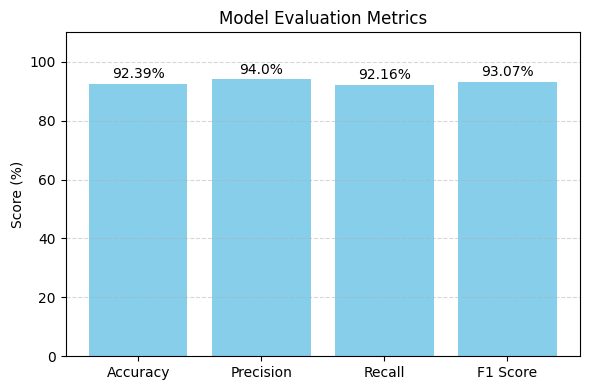

In [41]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# Define metrics
metrics = {
    "Accuracy": round(accuracy * 100, 2),
    "Precision": round(precision * 100, 2),
    "Recall": round(recall * 100, 2),
    "F1 Score": round(f1 * 100, 2),
}

# Create a DataFrame
df = pd.DataFrame(metrics, index=["Score (%)"]).T
print(df)

df.to_csv("Output/model_metrics.csv")       # For CSV

# Plot clean bar graph
plt.figure(figsize=(6, 4))
bars = plt.bar(df.index, df["Score (%)"], color='skyblue')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 110)
plt.ylabel("Score (%)")
plt.title("Model Evaluation Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Final_Metrics_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

# Plotting GRAPHS

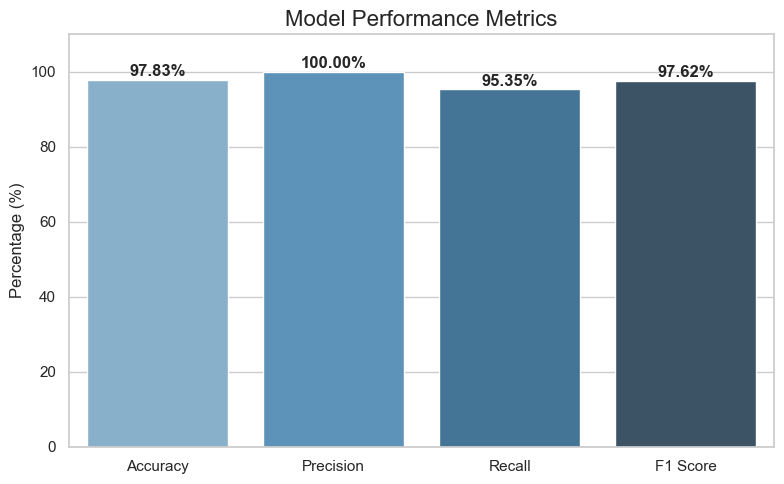

In [ ]:
# Bar Chart

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Define metrics
metrics = {
    "Accuracy": round(accuracy * 100, 2),
    "Precision": round(precision * 100, 2),
    "Recall": round(recall * 100, 2),
    "F1 Score": round(f1 * 100, 2),
}

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")

plt.title("Model Performance Metrics", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, 110)

for i, v in enumerate(metrics.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.tight_layout()

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Bar_Graph_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

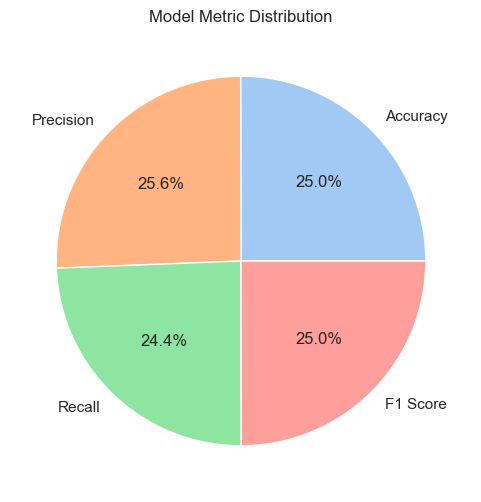

In [43]:
# Pie Chart Graph

plt.figure(figsize=(6, 6))
plt.pie(metrics.values(), labels=metrics.keys(), autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Model Metric Distribution")

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Pie_Chart_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

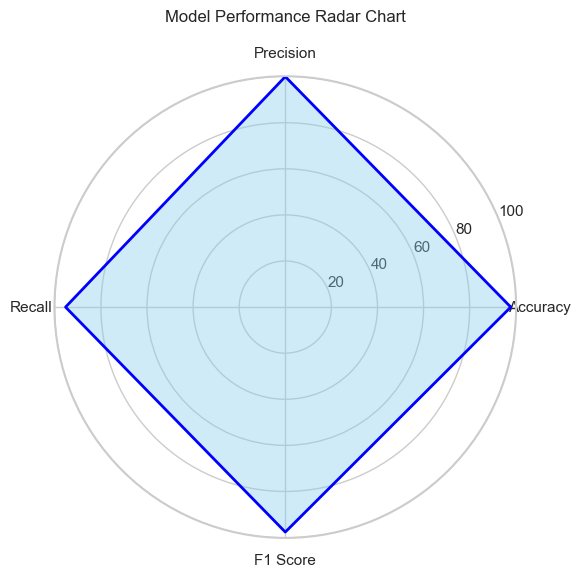

In [ ]:
# Radar (Spider) Chart

import matplotlib.pyplot as plt
import numpy as np
import time

# Use your existing metrics dictionary
metrics = {
    "Accuracy": round(accuracy * 100, 2),
    "Precision": round(precision * 100, 2),
    "Recall": round(recall * 100, 2),
    "F1 Score": round(f1 * 100, 2),
}

# Extract labels and values from metrics
labels = list(metrics.keys())
values = list(metrics.values())

# Close the radar chart loop
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='blue', linewidth=2)
ax.fill(angles, values, color='skyblue', alpha=0.4)

# Set the axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)

# Y-axis ticks and title
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=9)
ax.set_title("Model Performance Radar Chart", y=1.1, fontsize=14)

# Save the radar chart
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Spider_Chart_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

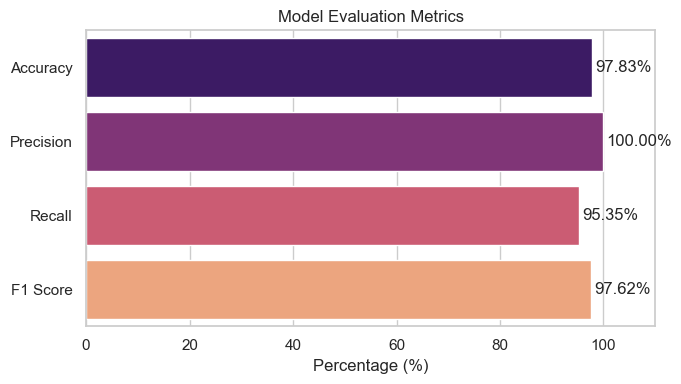

In [ ]:
# Horizontal Bar Plot

import seaborn as sns
import matplotlib.pyplot as plt

# Define metrics
metrics = {
    "Accuracy": round(accuracy * 100, 2),
    "Precision": round(precision * 100, 2),
    "Recall": round(recall * 100, 2),
    "F1 Score": round(f1 * 100, 2),
}

plt.figure(figsize=(7, 4))
sns.barplot(y=list(metrics.keys()), x=list(metrics.values()), palette='magma')
plt.xlabel("Percentage (%)")
plt.title("Model Evaluation Metrics")
for i, (k, v) in enumerate(metrics.items()):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.xlim(0, 110)
plt.tight_layout()

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Horizontal_Bar_chart_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

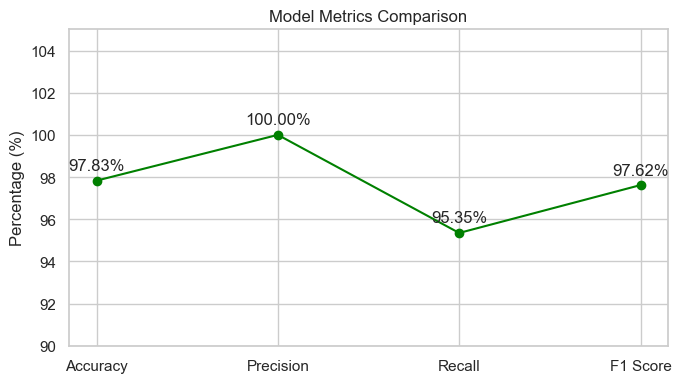

In [46]:
# Line Plot (Comparison Curve)

plt.figure(figsize=(7, 4))
plt.plot(list(metrics.keys()), list(metrics.values()), marker='o', linestyle='-', color='green')
plt.title("Model Metrics Comparison")
plt.ylabel("Percentage (%)")
plt.ylim(90, 105)
for i, (k, v) in enumerate(metrics.items()):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.grid(True)
plt.tight_layout()

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Line_chart_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

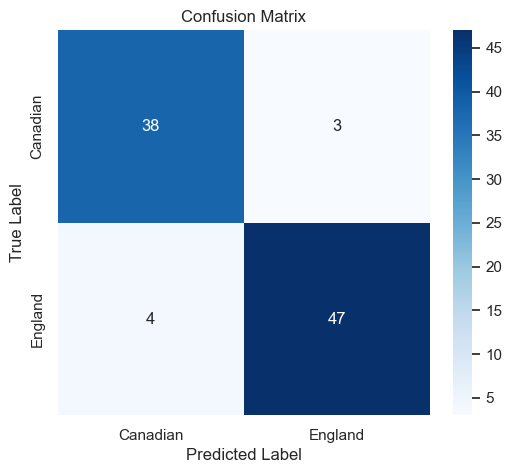

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Canadian", "England"], yticklabels=["Canadian", "England"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Confusion_Matrix_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

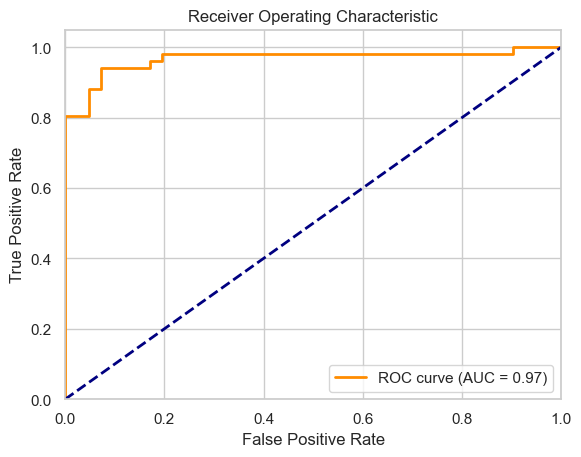

In [48]:
# 2. ROC Curve

y_probs = preds_output.predictions[:, 1]  # Probability for positive class (class 1)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/ROC_curve_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

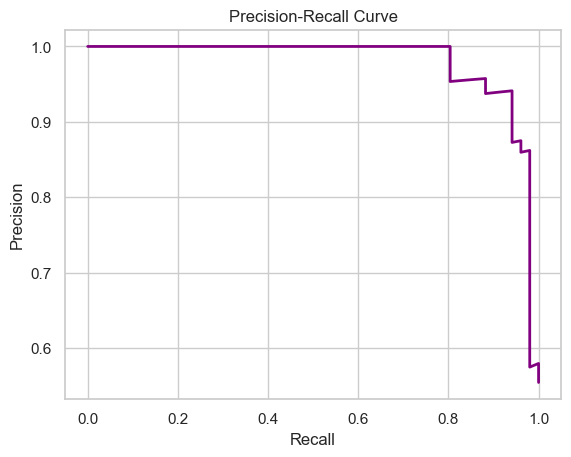

In [49]:
# 3. Precision-Recall Curve

precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
plt.figure()
plt.plot(recall_vals, precision_vals, color="purple", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Precision_Recall_curve_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

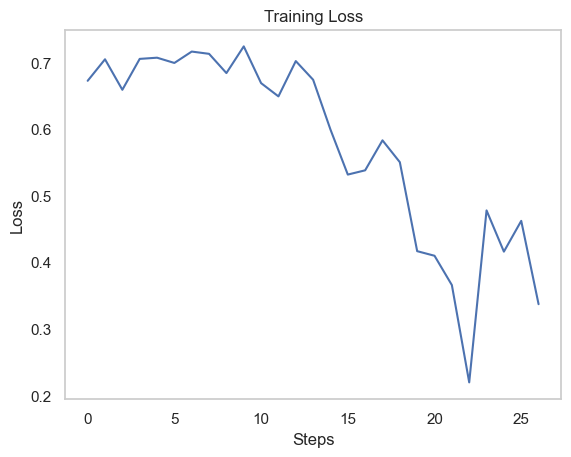

In [50]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
loss_values = [entry['loss'] for entry in log_history if 'loss' in entry]
plt.plot(loss_values)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid()

# Save the plot
timestamp = time.strftime("%d%m%Y-%H%M%S")
plt.savefig(f"Graphs/Training_Loss_curve_{timestamp}.png", dpi=300, bbox_inches='tight')

plt.show()

---

## 👨‍💻 Author

Made with ❤️ by [creativepurus](https://github.com/creativepurus)

[![LinkedIn: Connect with Me](https://img.shields.io/badge/Connect_on_LinkedIn-purple?style=flat-square&logo=linkedin&logoColor=white&labelColor=0a66c2&color=black)](https://www.linkedin.com/in/creativepurus/)

[LinkedIn](https://www.linkedin.com/in/creativepurus/) | [GitHub](https://github.com/creativepurus)

---

### Love My Work ? You can 👉🏻 [![BUY ME A COFFEE](https://img.shields.io/badge/Buy%20Me%20a%20Coffee%20☕-%23FFDD00.svg?&style=for-the-badge&logo=buy-me-a-coffee&logoColor=black)](https://www.buymeacoffee.com/creativepurus)